In [1]:
import os
import numpy as np
import pandas as pd
from nilearn import masking, image
from scipy.stats import ttest_1samp, pearsonr, ttest_ind,ttest_rel
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
sns.set_style('white')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

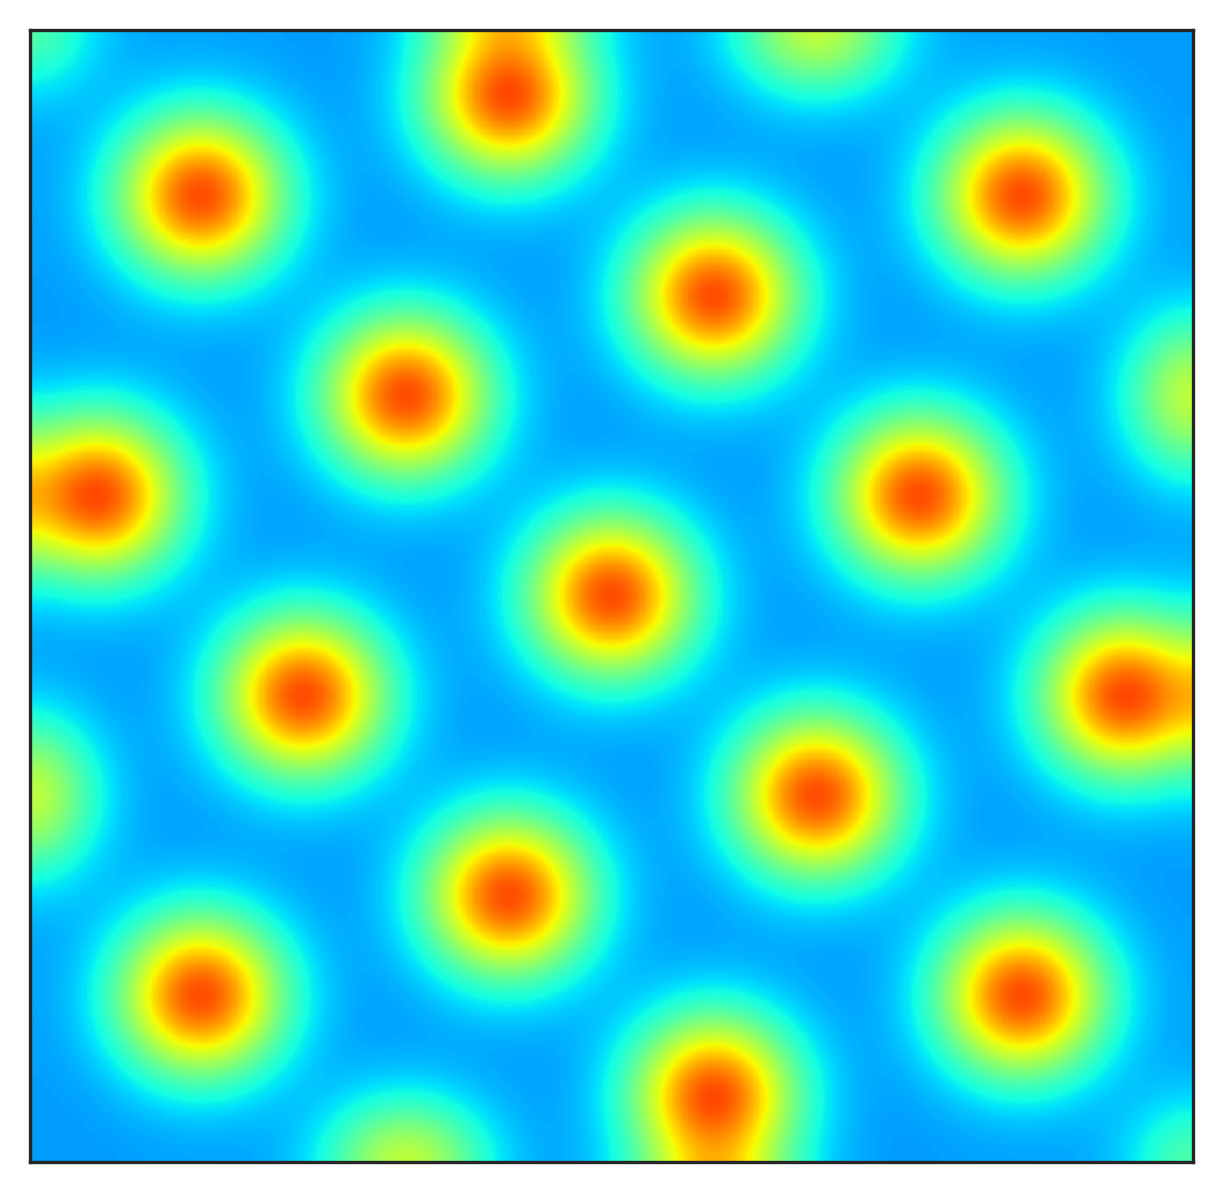

In [102]:
import seaborn as sns
from scipy.ndimage import gaussian_filter


def firing_pattern(x, y, scale, field_radius, orientation):
    # Create a hexagonal grid of firing field centers
    x_coords = np.arange(-scale, scale + 1)
    y_coords = np.arange(-scale, scale + 1)
    xx, yy = np.meshgrid(x_coords, y_coords)
    centers = np.column_stack((xx.flatten(), yy.flatten())).astype(np.float64) * scale
    centers[:, 0] += 0.5 * (centers[:, 1] % 2) * scale

    # Apply the rotation matrix to the centers
    rotation_matrix = np.array([[np.cos(orientation), -np.sin(orientation)],
                                [np.sin(orientation), np.cos(orientation)]])
    centers = centers @ rotation_matrix

    # Calculate the firing rate at each (x, y) position
    firing_rate = np.zeros_like(x)
    for center in centers:
        distance = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
        firing_rate += np.exp(-distance ** 2 / (2 * field_radius ** 2))
    return firing_rate


# Define the parameters for the grid cell
scale = 5
field_radius = 0.8
orientation = np.pi / 4  # 30 degrees

# Create a grid of x and y coordinates
x = np.linspace(-scale * 2, scale * 2, 1000)
y = np.linspace(-scale * 2, scale * 2, 1000)
xx, yy = np.meshgrid(x, y)

# Compute the firing pattern of the grid cell
firing_rate = firing_pattern(xx, yy, scale, field_radius, orientation)

# Apply Gaussian smoothing to the firing rate data
sigma = 30
smoothed_firing_rate = gaussian_filter(firing_rate, sigma)


# Normalization function
def normalize_data(data, min_value, max_value):
    normalized_data = (data - np.min(data)) / (np.max(data) - np.min(data))
    return normalized_data * (max_value - min_value) + min_value


# Apply normalization to the smoothed firing rate data
min_value = 0
max_value = 1
normalized_smoothed_firing_rate = normalize_data(smoothed_firing_rate, min_value, max_value)
# Plot the firing pattern
plt.figure(figsize=(5, 5), dpi=300, frameon=False)
#plt.imshow(normalized_smoothed_firing_rate, cmap="gray", origin="lower")
plt.pcolormesh(x,y,normalized_smoothed_firing_rate,cmap='jet',shading='auto', vmax=1.3, vmin=-0.5)
#sns.heatmap(normalized_smoothed_firing_rate,cmap='get')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.savefig("/mnt/workdir/DCM/Result/paper/figure2/firing_pattern.pdf", dpi=300, bbox_inches='tight', transparent=True,pad_inches=0)
plt.show()

<ipython-input-42-eaa15afae1d7>:10: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='ifold', y="statistic", data=data,alpha=0.5,size=5,


ifold 4fold - t-statistic: -0.351, p-value: 0.637
ifold 5fold - t-statistic: 0.407, p-value: 0.342
ifold 6fold - t-statistic: 3.198, p-value: 0.001
ifold 7fold - t-statistic: 1.583, p-value: 0.059
ifold 8fold - t-statistic: 0.515, p-value: 0.304


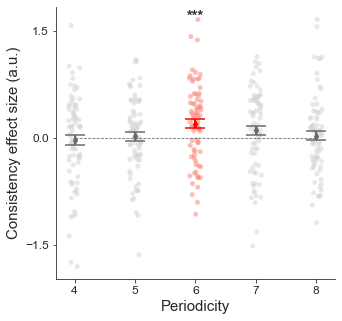

In [42]:
data = pd.read_csv(r'/mnt/workdir/DCM/Result/analysis/Specificity_to_6/nilearn_cv/sub_stats-z_roi-ec_trial-even.csv')
# high performance filter
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
hp_info = participants_data.query(f'(game1_fmri>=0.5)and(game1_acc>0.8)')  # look out
hp_sub = hp_info['Participant_ID'].to_list()
data = data.loc[data['sub_id'].isin(hp_sub)]

fig, ax = plt.subplots(figsize=(5, 5))
sns.stripplot(x='ifold', y="statistic", data=data,alpha=0.5,size=5,
              palette=["lightgray", "lightgray", 'salmon', "lightgray", "lightgray"],zorder=1)
x = [0,1,2,3,4]
y = [0]*len(x)
plt.plot(x, y, linestyle='--', color='black',linewidth=0.8,alpha=0.6)

# Calculate SEM for each group
sem = data.groupby('ifold')['statistic'].sem().values
# Plot error bars
palette=["dimgray", "dimgray", 'red', "dimgray", "dimgray"]
for i, group in enumerate(data.groupby('ifold')):
    ax.errorbar(i, group[1]['statistic'].mean(), yerr=sem[i], fmt='none', color=palette[i], capsize=10,capthick=1.5,linewidth=2,zorder=4)
    plt.plot(i,group[1]['statistic'].mean(), marker='d', markersize=5,color=palette[i],zorder=3)

plt.xticks([0,1,2,3,4],[4,5,6,7,8],size=12)
plt.yticks([-1.5,0,1.5],size=12)


plt.xlabel('Periodicity',size=15)
plt.ylabel('Consistency effect size (a.u.)',size=15)

# remove the box lines of the axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# Add asterisks on top of each bar
vmean = np.max(data['ifold']=='6fold')
# Group the data by 'ifold'
grouped_data = data.groupby('ifold')

# Perform statistical tests for each 'ifold'
for i, group in grouped_data:
    # Extract the statistic values for the current 'ifold' group
    statistics = group['statistic'].values

    # Perform a statistical test (e.g., t-test) against a null hypothesis
    # Here, we assume the null hypothesis that the mean is zero
    t_statistic, p_value = ttest_1samp(statistics, 0,alternative='greater')

    # Print the results
    t_statistic = round(t_statistic, 3)
    p_value = round(p_value, 3)
    print(f"ifold {i} - t-statistic: {t_statistic}, p-value: {p_value}")

    # Add asterisks on top of each bar based on significance level
    if p_value <= 0.001:
        ax.text(i, vmean + 0.6, '***', ha='center', va='bottom', weight='bold', size=15)
    elif p_value < 0.01:
        ax.text(i, vmean + 0.6, '**', ha='center', va='bottom', weight='bold', size=15)
    elif p_value < 0.05:
        ax.text(i, vmean + 0.6, '*', ha='center', va='bottom', weight='bold', size=15)

ax.tick_params(axis='x', which='both', bottom=True, top=False, direction='out')
ax.tick_params(axis='y', which='both', left=True, right=False, direction='out')
# #plt.title("HP participants(num={})".format(sub_num),size=16)
plt.savefig(r'/mnt/workdir/DCM/Result/paper/figure2/Specificity_to_6fold.pdf',bbox_inches='tight',pad_inches=0,dpi=300,transparent=True)
plt.show()

In [9]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query('(game1_fmri>=0.5)and(game1_acc>0.8)')  # look out
subjects = data['Participant_ID'].to_list()
num = len(subjects)
# set camp
cmap_template = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/distance_spct/Setall/6fold/{}/zmap/M2_corrxdistance_zmap.nii.gz'
sub_cmap_paths = [cmap_template.format(sub_id) for sub_id in subjects]

# set roi
roi1 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/lHC_MNI152NL.nii.gz')
roi2 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/rHC_MNI152NL.nii.gz')
hc = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
ec = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
#ec = image.load_img(r'/mnt/data/DCM/result_backup/2023.4.17/game1/hexagon_spct/EC_thr3.1.nii.gz')
ec = image.binarize_img(ec,10)

# extract mean activity of ROI for each subjects
subs_hc_mact = np.mean(masking.apply_mask(sub_cmap_paths, hc), axis=1)
subs_ec_mact = np.mean(masking.apply_mask(sub_cmap_paths, ec), axis=1)

# mean
t_statistic, p_value = ttest_1samp(subs_hc_mact, 0)
print("HC's t:", t_statistic)
print("HC's p:", p_value)

t_statistic, p_value = ttest_1samp(subs_ec_mact, 0)
print("EC's t:", t_statistic)
print("EC's p:", p_value)

/home/dell/Software/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


HC's t: 4.611043484149666
HC's p: 1.6408187540149198e-05
EC's t: 1.9030128815386083
EC's p: 0.060928829789758464


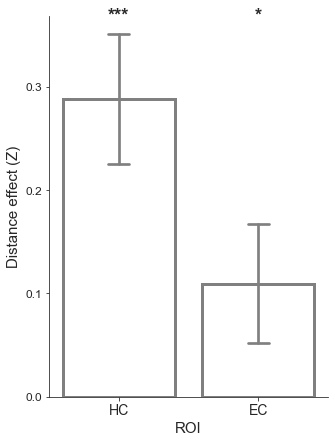

In [199]:
distance_bar = pd.DataFrame({'HC':subs_hc_mact,'EC':subs_ec_mact})
# adjust data format to plot
distance_bar = pd.melt(distance_bar,  value_vars=['HC', 'EC'], var_name='ROI', value_name='Distance effect (Z)')
# Initialize a Figure and Axes
fig, ax = plt.subplots(figsize=(5,7))
sns.barplot(
    data=distance_bar,
    x="ROI", y="Distance effect (Z)",
    errorbar="se", capsize=.15, errcolor="0.5",
    linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0),
    ax=ax
)
# Loop over the bars, and add a '*' label
for i, bar in enumerate(ax.containers[0]):
    height = bar.get_height()
    if i == 0:
        ax.text(bar.get_x() + bar.get_width() / 2, 0.36, "***", ha='center', va='bottom', fontsize=18,fontweight='bold')
    elif i == 1:
        ax.text(bar.get_x() + bar.get_width() / 2, 0.36, "*", ha='center', va='bottom', fontsize=18,fontweight='bold')

ax.set_xlabel('ROI', fontsize=15)
ax.set_ylabel('Distance effect (Z)', fontsize=15)
# Adjust the tick parameters
# Add tick lines to the bottom and left spines
ax.tick_params(axis='x', which='both', bottom=True, top=False, direction='out')
ax.tick_params(axis='y', which='both', left=True, right=False, direction='out')
# remove the box lines of the axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# Set custom ticks for the x-axis and y-axis
plt.yticks([0,0.10,0.20,0.30],size=12)
plt.xticks(size=14)
#plt.savefig(r'/mnt/workdir/DCM/Result/paper/supplementary figure2/distance_roi_hc&ec.pdf',bbox_inches='tight',pad_inches=0,dpi=300,transparent=True)
plt.show()

In [9]:
# plot align vs misalign

# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query('(game1_fmri>=0.5)and(game1_acc>0.8)')
subjects = data['Participant_ID'].to_list()
num = len(subjects)

# set camp
algin_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/cv_test_align_spct/Setall/6fold/{}/zmap/m2_alignPhi_even_zmap.nii.gz'
misalgin_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/cv_test_align_spct/Setall/6fold/{}/zmap/m2_misalign_even_zmap.nii.gz'

sub_algin_cmaps = [algin_template.format(sub_id) for sub_id in subjects]
sub_misalgin_cmaps = [misalgin_template.format(sub_id) for sub_id in subjects]

# load mask
ec = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
ec = image.binarize_img(ec,10)
#ec = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/hexagon_spct/EC_thr3.1.nii.gz'
#ec = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/func/alignPhi_even_zmap_thr2.3.nii.gz')

# load data
subs_align_mact = np.mean(masking.apply_mask(sub_algin_cmaps, ec), axis=1)
subs_misalign_mact = np.mean(masking.apply_mask(sub_misalgin_cmaps, ec), axis=1)

# demean for each subjects
mean_mact = np.mean(subs_align_mact+subs_misalign_mact,axis=0)
subs_mact = np.concatenate((subs_align_mact-mean_mact,subs_misalign_mact-mean_mact),axis=0)
subs_align_mact = subs_align_mact-mean_mact
subs_misalign_mact = subs_misalign_mact-mean_mact
align_data = pd.DataFrame({'Activity':subs_mact,'Group':num*['Align']+num*['Misalign']})

/home/dell/Software/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


In [8]:
# mean
t_statistic, p_value = ttest_1samp(subs_align_mact, 0)
print("Align's t:", t_statistic)
print("Align's p:", p_value)

t_statistic, p_value = ttest_1samp(subs_misalign_mact, 0)
print("Misalign's t:", t_statistic)
print("Misalign's p:", p_value)

t_statistic, p_value = ttest_rel(subs_align_mact, subs_misalign_mact)
print("Align vs Misalign's t:", t_statistic)
print("Align vs Misalign's p:", p_value)

Align's t: 16.84165693836668
Align's p: 4.9971528854208325e-27
Misalign's t: -1.506579593271729
Misalign's p: 0.13617560799318795
Align vs Misalign's t: 9.25384014921927
Align vs Misalign's p: 5.524168378512977e-14


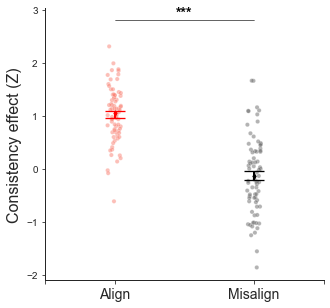

In [72]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(5,5))

# Pre-calculated means and standard errors
means = [subs_align_mact.mean(), subs_misalign_mact.mean()]
errors = [np.std(subs_align_mact, ddof=1) / np.sqrt(len(subs_align_mact)),
          np.std(subs_misalign_mact, ddof=1) / np.sqrt(len(subs_misalign_mact))]

# Configurations for both conditions
colors = [['salmon','red'], ['dimgray','black']]
x_vals = [-0.5, 0.5]
data_sets = [subs_align_mact, subs_misalign_mact]
x_jitters = [np.random.uniform(-0.05, 0.05,size=len(subs_align_mact)) - 0.5,
             np.random.uniform(-0.05, 0.05,size=len(subs_misalign_mact)) + 0.5]

# Plotting for both conditions
for i in range(2):
    sns.scatterplot(x=x_jitters[i], y=data_sets[i], alpha=0.5, color=colors[i][0], size=5, zorder=1)
    bar = sns.barplot(x=[x_vals[i]], y=[means[i]], alpha=0, color='None', capsize=0.1, errcolor='blue', errwidth=1.5, error_kw={'ecolor':'blue'})
    bar.errorbar(x=[x_vals[i]], y=[means[i]], yerr=[errors[i]], fmt='none', ecolor=colors[i][1], capsize=10,capthick=1.3, linewidth=2, zorder=2)
    plt.plot(x_vals[i], means[i]*1.02, marker='d', markersize=3.8, color=colors[i][1], zorder=3)

ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Consistency effect (Z)', size=16)

plt.plot([-0.5, 0.5], [2.8, 2.8], color='black', linewidth=0.6)
plt.text(0, 2.8, "***", ha='center', va='bottom', fontsize=14, fontweight='bold', color='black')

plt.xticks([-1, -0.5, 0.5 ,1], ['','Align','Misalign',''], size=14)

ax.tick_params(axis='x', which='both', bottom=True, top=False, direction='out')
ax.tick_params(axis='y', which='both', left=True, right=False, direction='out')
plt.legend().remove()
plt.savefig(r'/mnt/workdir/DCM/Result/paper/figure2/cv_6fold_align_misalign_cv-roi.pdf',bbox_inches='tight',pad_inches=0,dpi=300,transparent=True)
plt.show()

In [66]:
# plot align vs misalign 12 bin
def get_subs_act(cmaps,roi):
    subs_mact = []
    for cmap in cmaps:
        # check the file of cmaps exist
        if not os.path.exists(cmap):
            print(f'The cmaps:{cmap} does not exist.')
            subs_mact.append(np.nan)
        else:
            # calculate mean activity in ROI
            sub_mact = np.mean(masking.apply_mask(cmap, roi))
            subs_mact.append(sub_mact)
    return subs_mact


# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query('(game1_fmri>=0.5)and(game1_acc>0.8)')
subjects = data['Participant_ID'].to_list()
subjects.sort()
num = len(subjects)

# load mask
#ec = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
#ec = image.binarize_img(ec,10)
#ec = image.load_img(r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/hexagon_spct/EC_thr3.1.nii.gz')
ec = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/func/alignPhi_even_zmap_thr2.3.nii.gz')
#ec = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/hexagon_spct/EC_thr3.1.nii.gz'

# load data
bin12 = pd.DataFrame()
# set camp
template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/cv_test_align_spct/Setall/6fold/{}/zmap/{}_{}_{}_{}_zmap.nii.gz'

for onset in ['m2']:
    for parity in ['even']:
        for bin in range(1,13,1):
            if bin in range(1,13,2):
                cmaps = [template.format(sub_id,onset,'align',str(bin),parity) for sub_id in subjects]
            elif bin in range(2,13,2):
                cmaps = [template.format(sub_id,onset,'misalign',str(bin),parity) for sub_id in subjects]
            subs_mact = get_subs_act(cmaps,ec)
            bin12 = bin12.append(pd.DataFrame({'Activity':subs_mact,'Direction of mental trajectory':bin,
                                           'hue':'Align' if bin in range(1,13,2) else 'Misalign','sub_id':subjects,
                                           'onset':onset,'parity':parity}))

<Axes: xlabel='Direction of mental trajectory', ylabel='zscore'>

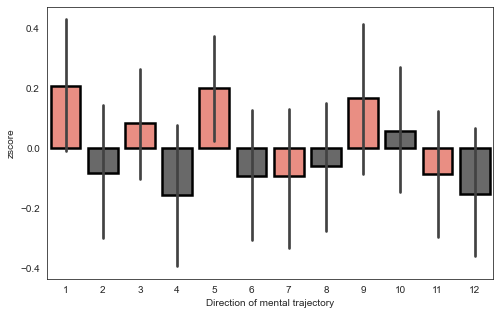

In [181]:
# Zscore for acitivity
bin12['zscore'] = bin12.groupby('sub_id')['Activity'].transform(lambda x: (x - x.mean())/x.std())
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(data=bin12,x='Direction of mental trajectory',y='zscore',palette=['salmon','dimgray'],edgecolor='black',linewidth=2.5)

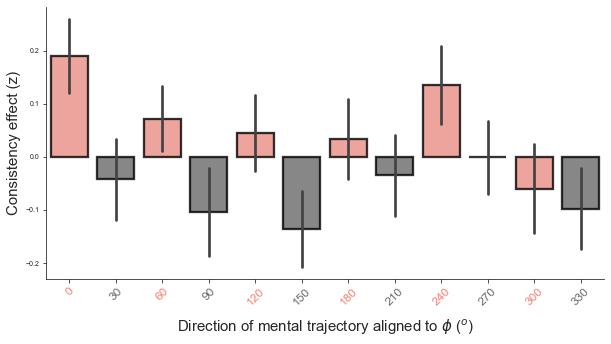

In [101]:
# Demean for acitivity
bin12['Activity_demean'] = bin12['Activity'] - bin12['Activity'].mean()
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data=bin12,x='Direction of mental trajectory',y='Activity_demean',errorbar='se',palette=['salmon','dimgray'],edgecolor='black',linewidth=2.3,alpha=0.8,capsize=0)

# remove the box lines of the axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# add labels
# add labels
# add labels
ax.set_xlabel('Direction of mental trajectory aligned to ${\it\phi}$ ($^{o}$)', size=15, labelpad=10)
ax.set_ylabel('Consistency effect (z)',size=15)

# Set custom ticks for the x-axis and y-axis
plt.xticks(range(0,12),range(0,360,30),size=12,rotation=45)
xticks = ax.get_xticklabels()
colors = ['salmon', 'dimgray']
for i, label in enumerate(xticks):
    label.set_color(colors[i % len(colors)])
# Add tick lines to the bottom and left spines
ax.tick_params(axis='x', which='both', bottom=True, top=False, direction='out')
ax.tick_params(axis='y', which='both', left=True, right=False, direction='out')
plt.savefig(r'/mnt/workdir/DCM/Result/paper/figure2/cv_6fold_align_misalign_12bin_cv_func_EC_roi.pdf',bbox_inches='tight',pad_inches=0,dpi=300,transparent=True)
plt.show()